# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [3]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [4]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [5]:
## parsing data here
images, labels = parse_data(df)


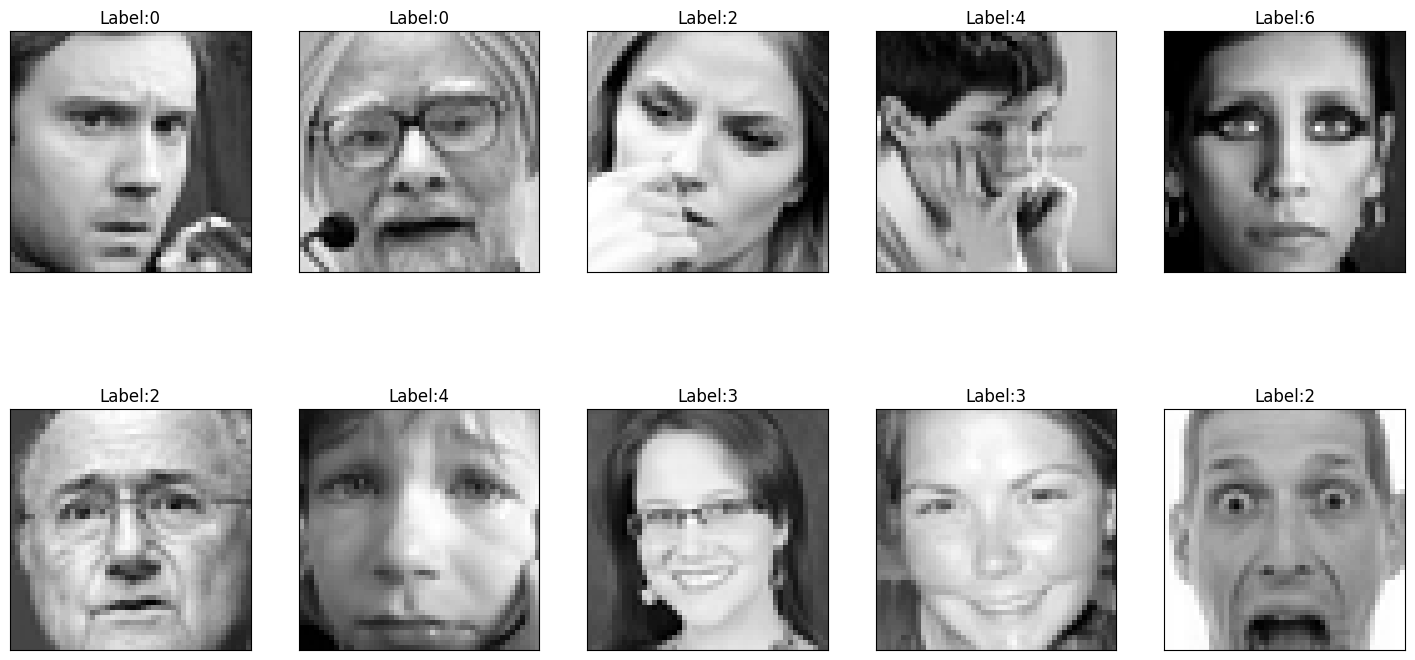

In [6]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [7]:
from sklearn.decomposition import PCA

num_samples, height, width = images.shape
images_reshaped = images.reshape(num_samples, height * width)

pca=PCA(n_components=2)
pca.fit(images_reshaped) ## modify images' array to the appropriate shape

PCA(n_components=2)

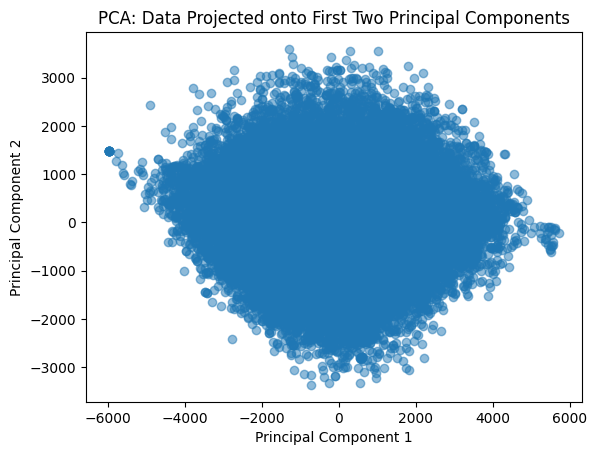

(35887, 2)

In [8]:
## transform for visualizing here
# images_pca=pca.transform(images) ## modify images' array to the appropriate shape
# images_pca.shape

images_pca = pca.transform(images_reshaped)

import matplotlib.pyplot as plt

# Create a scatter plot of the projected data
plt.scatter(images_pca[:, 0], images_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Data Projected onto First Two Principal Components')
plt.show()

# Check the shape of the transformed data
images_pca.shape

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

Determining the Optimal Number of Principal Components
To determine the optimal number of principal components (PCs), we can use the explained variance ratio provided by the PCA model. The explained variance ratio indicates how much variance in the data is captured by each principal component. The goal is to select the smallest number of PCs that capture most of the variance in the data.

The selection process involves the following steps:

- Compute Cumulative Explained Variance: Calculate the cumulative sum of the explained variance ratios. This gives us the cumulative variance captured by the first 𝑘 principal components.
- Determine Threshold for Explained Variance: Decide on a threshold for the cumulative explained variance (e.g., 90% or 95%). This threshold represents the desired amount of total variance we want to capture.
- Find the Number of Components: Identify the smallest number of principal components required to reach or exceed the chosen threshold.

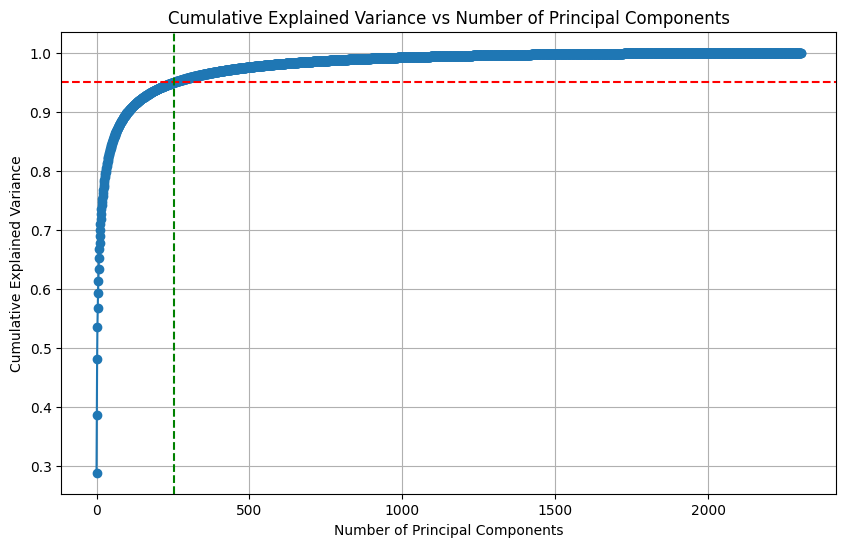

255

In [9]:
## determine the optimal number of PCs here
## pca.explained_variance_()

# Fit PCA to the reshaped data
pca = PCA()
pca.fit(images_reshaped)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the optimal number of PCs
threshold = 0.95  # e.g., we want to capture 95% of the variance
optimal_num_pcs = np.argmax(cumulative_explained_variance >= threshold) + 1

# Plot cumulative explained variance to visualize the selection process
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=optimal_num_pcs-1, color='g', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.grid()
plt.show()

optimal_num_pcs

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [27]:
from sklearn.model_selection import train_test_split

# Assuming images and labels are already defined
# Flatten images if they are not already flattened
num_samples, height, width = images.shape
images_reshaped = images.reshape(num_samples, height * width)

# Split the data into training and temporary sets (80% training, 20% temporary)
images_train, images_temp, labels_train, labels_temp = train_test_split(images_reshaped, labels, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets (50% validation, 50% test of the 20% temporary set)
images_val, images_test, labels_val, labels_test = train_test_split(images_temp, labels_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {images_train.shape}, {labels_train.shape}")
print(f"Validation set shape: {images_val.shape}, {labels_val.shape}")
print(f"Test set shape: {images_test.shape}, {labels_test.shape}")

Training set shape: (28709, 2304), (28709,)
Validation set shape: (3589, 2304), (3589,)
Test set shape: (3589, 2304), (3589,)


In [33]:
from sklearn.decomposition import PCA

# Define the optimal number of principal components (e.g., from previous analysis)
optimal_num_pcs = 50  

# Fit PCA on the training set and transform the training, validation, and test sets
pca = PCA(n_components=optimal_num_pcs)
pca.fit(images_train)

images_train_pca = pca.transform(images_train)
images_val_pca = pca.transform(images_val)
images_test_pca = pca.transform(images_test)

print(f"Transformed training set shape: {images_train_pca.shape}")
print(f"Transformed validation set shape: {images_val_pca.shape}")
print(f"Transformed test set shape: {images_test_pca.shape}")

Transformed training set shape: (28709, 50)
Transformed validation set shape: (3589, 50)
Transformed test set shape: (3589, 50)


#### Define and Tune Classification Algorithms

- Support Vector Machine (SVM)
- Random Forest
- k-Nearest Neighbors (k-NN)
- Multi-Layer Perceptron (MLP)

In [39]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the classifiers with default hyperparameters
classifiers = {
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=1000)
}

# Train and evaluate models on both original and PCA-transformed data
results = {}  # Dictionary to store classification reports and confusion matrices

for clf_name, clf in classifiers.items():
    # Train and evaluate on PCA-transformed data
    clf.fit(images_train_pca, labels_train)
    y_pred_pca = clf.predict(images_test_pca)
    
    # Calculate classification report
    report = classification_report(labels_test, y_pred_pca, zero_division=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(labels_test, y_pred_pca)
    
    # Store results
    results[clf_name] = {
        'classification_report': report,
        'confusion_matrix': cm
    }
    
    # Print classification report
    print(f"Classification report for {clf_name} (PCA-transformed data):\n")
    print(report)

Classification report for SVM (PCA-transformed data):

              precision    recall  f1-score   support

           0       0.39      0.21      0.27       480
           1       1.00      0.03      0.06        60
           2       0.39      0.23      0.29       515
           3       0.48      0.73      0.58       883
           4       0.33      0.39      0.35       597
           5       0.61      0.53      0.56       397
           6       0.42      0.40      0.41       657

    accuracy                           0.44      3589
   macro avg       0.52      0.36      0.36      3589
weighted avg       0.44      0.44      0.42      3589

Classification report for RandomForest (PCA-transformed data):

              precision    recall  f1-score   support

           0       0.49      0.20      0.29       480
           1       1.00      0.33      0.50        60
           2       0.58      0.31      0.41       515
           3       0.41      0.80      0.54       883
           4 

#### Hyperparameter Tuning and Evaluation

In [35]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the classifiers and their hyperparameter grids
classifiers = {
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=100)
}

param_grids = {
    'SVM': {'C': [1], 'kernel': ['linear', 'rbf']},
    'RandomForest': {'n_estimators': [100], 'max_depth': [None, 10]},
    'KNN': {'n_neighbors': [5]},
    'MLP': {'hidden_layer_sizes': [(100,)], 'activation': ['relu']}
}

best_estimators = {}

# Perform GridSearchCV for each classifier
for clf_name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[clf_name], cv=5, n_jobs=-1)
    
    # Fit and find the best estimator for the PCA-transformed data
    grid_search.fit(images_train_pca, labels_train)
    best_estimators[clf_name + '_PCA'] = grid_search.best_estimator_
    print(f"Best parameters for {clf_name} (PCA data): {grid_search.best_params_}")

# Evaluate the performance of each best estimator
for clf_name, best_estimator in best_estimators.items():
    if 'PCA' in clf_name:
        y_pred = best_estimator.predict(images_test_pca)
    else:
        y_pred = best_estimator.predict(images_test)
    
    print(f"Classification report for {clf_name}:\n")
    print(classification_report(labels_test, y_pred))


KeyboardInterrupt: 

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



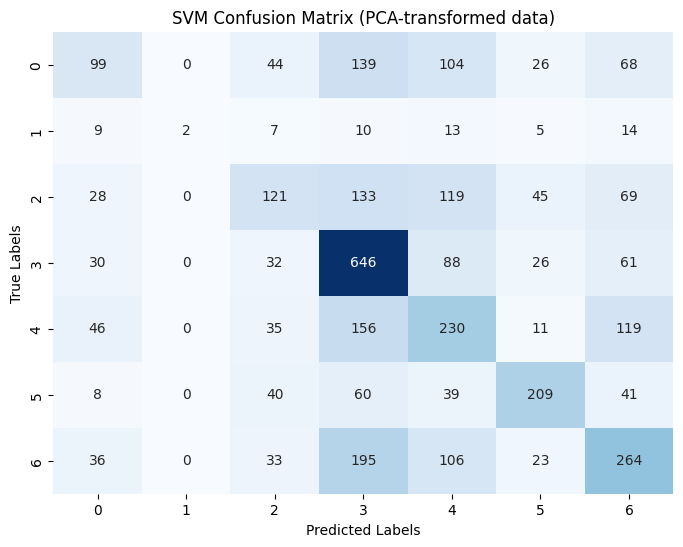

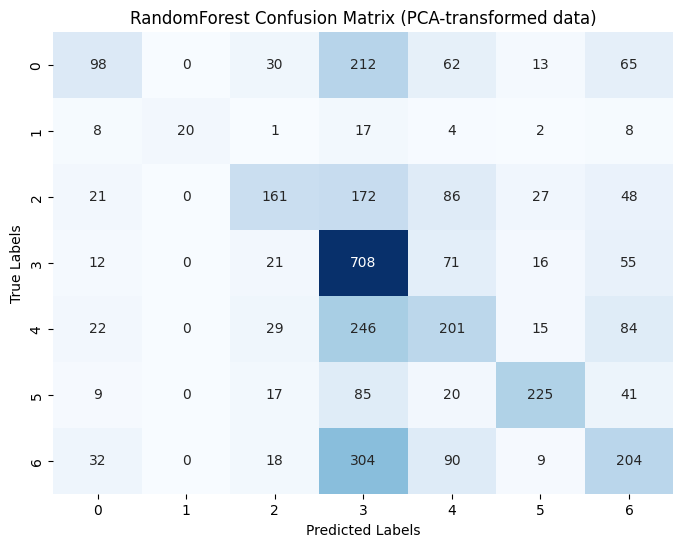

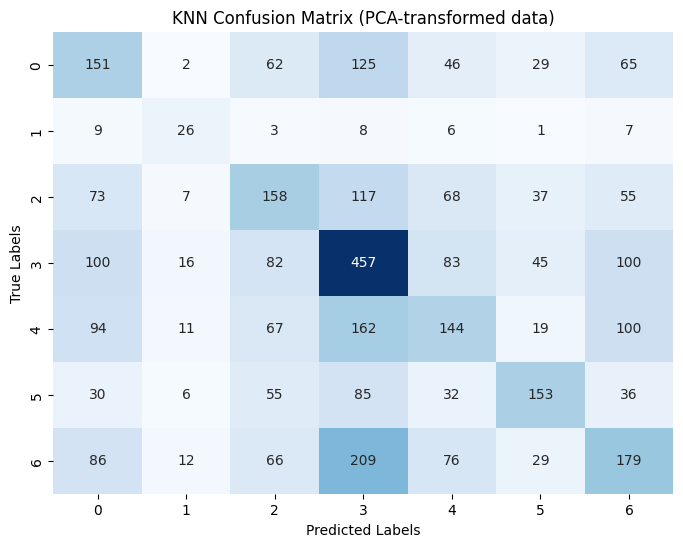

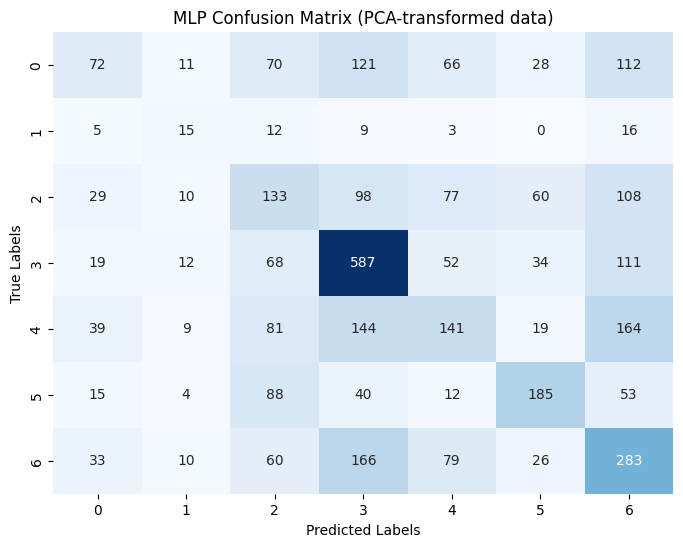

In [40]:
# Visualize confusion matrices
for clf_name, result in results.items():
    cm = result['confusion_matrix']
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{clf_name} Confusion Matrix (PCA-transformed data)')
    plt.show()
